<a href="https://colab.research.google.com/github/sayakpaul/Sharpness-Aware-Minimization-TensorFlow/blob/main/SAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook how to minimally implement **sharpness-aware minimization** in TensorFlow with the CIFAR10 dataset. Sharpness-aware minimization (SAM) was proposed in the paper - [Sharpness-Aware Minimization for Efficiently Improving Generalization](https://openreview.net/pdf?id=6Tm1mposlrM)<sup>*</sup>. Some notable differences in this implementation: 
* ResNet20 (attributed to [this repository](https://github.com/GoogleCloudPlatform/keras-idiomatic-programmer/blob/master/zoo/resnet/resnet_cifar10.py)) is used as opposed to PyramidNet and WideResNet. 
* ShakeDrop regularization has not been used.
* Two simple augmentation transformations (random crop and random brightness) have been used as opposed to Cutout, AutoAugment. 
* Adam has been used as the optimizer with the default arguments as provided by TensorFlow with a `ReduceLROnPlateau`. Table 1 of the original paper suggests to use SGD with different configurations. 
* Instead of training for full number of epochs I used early stopping with a patience of 10.

I referred to the following resources for this study - 
* [Original Paper](https://openreview.net/pdf?id=6Tm1mposlrM) 
* [davda54](https://github.com/davda54)'s [PyTorch implementation](https://github.com/davda54/sam)

*<sub>arXiv version of the paper can be found [here](https://arxiv.org/abs/2010.01412).</sub>

## Initial Setup

In [ ]:
!git clone https://github.com/sayakpaul/Sharpness-Aware-Minimization-TensorFlow

fatal: destination path 'Sharpness-Aware-Minimization-TensorFlow' already exists and is not an empty directory.


In [ ]:
import sys
sys.path.append("Sharpness-Aware-Minimization-TensorFlow")

In [ ]:
import tensorflow as tf
tf.random.set_seed(42)
print(tf.__version__)

2.7.0


In [ ]:
try: # detect TPUs
    tpu = None
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError: # detect GPUs
    strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines

print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.13.87.194:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.13.87.194:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Number of accelerators:  8


In [ ]:
import matplotlib.pyplot as plt
import resnet_cifar10
import utils
import time

## Load Dataset and Prepare Data Loaders

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print(f"Training samples: {len(x_train)}")
print(f"Testing samples: {len(x_test)}")

Training samples: 50000
Testing samples: 10000


In [ ]:
BATCH_SIZE = 128 * strategy.num_replicas_in_sync
print(f"Batch size: {BATCH_SIZE}")
AUTO = tf.data.AUTOTUNE

def scale(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.cast(label, tf.int32)
    return image, label

def augment(image,label):
    image = tf.image.resize_with_crop_or_pad(image, 40, 40) # Add 8 pixels of padding
    image = tf.image.random_crop(image, size=[32, 32, 3]) # Random crop back to 32x32
    image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
    image = tf.clip_by_value(image, 0., 1.)

    return image, label

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = (
    train_ds
    .shuffle(1024)
    .map(scale, num_parallel_calls=AUTO)
    .map(augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = (
    test_ds
    .map(scale, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

Batch size: 1024


## Encapsulate SAM Logic 

SAM is implemented as follows - 

<center>
<img src="https://i.ibb.co/qRSfNX7/image.png"></img><br>
<small>Source: Original Paper</small>
</center>

In [ ]:
import tensorflow as tf
tf.config.run_functions_eagerly(False)

class SAMModel(tf.keras.Model):
    def __init__(self, resnet_model, rho=0.05):
        """
        p, q = 2 for optimal results as suggested in the paper
        (Section 2)
        """
        super(SAMModel, self).__init__()
        self.resnet_model = resnet_model
        self.rho = rho

    def train_step(self, data):
        (images, labels) = data
        e_ws = []
        with tf.GradientTape() as tape:
            predictions = self.resnet_model(images)
            loss = self.compiled_loss(labels, predictions)
        trainable_params = self.resnet_model.trainable_variables
        gradients = tape.gradient(loss, trainable_params)
        grad_norm = self._grad_norm(gradients)
        scale = self.rho / (grad_norm + 1e-12)

        for (grad, param) in zip(gradients, trainable_params):
            e_w = grad * scale
            param.assign_add(e_w)
            e_ws.append(e_w)

        with tf.GradientTape() as tape:
            predictions = self.resnet_model(images)
            loss = self.compiled_loss(labels, predictions)    
        
        sam_gradients = tape.gradient(loss, trainable_params)
        for (param, e_w) in zip(trainable_params, e_ws):
            param.assign_sub(e_w)
        
        self.optimizer.apply_gradients(
            zip(sam_gradients, trainable_params))
        
        self.compiled_metrics.update_state(labels, predictions)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        (images, labels) = data
        predictions = self.resnet_model(images, training=False)
        loss = self.compiled_loss(labels, predictions)
        self.compiled_metrics.update_state(labels, predictions)
        return {m.name: m.result() for m in self.metrics}

    def _grad_norm(self, gradients):
        norm = tf.norm(
            tf.stack([
                tf.norm(grad) for grad in gradients if grad is not None
            ])
        )
        return norm

## Define Callbacks

In [ ]:
train_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5,
        patience=3, verbose=1
    )
]

## Initialize Model with SAM and Train It

In [ ]:
with strategy.scope():
    model = SAMModel(utils.get_training_model())
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
print(f"Total learnable parameters: {model.resnet_model.count_params()/1e6} M")

Total learnable parameters: 0.575114 M


In [ ]:

start = time.time()
history = model.fit(train_ds,
                   validation_data=test_ds,
                   callbacks=train_callbacks,
                   epochs=100)
print(f"Total training time: {(time.time() - start)/60.} minutes")

Epoch 1/100
Instructions for updating:
use `experimental_local_results` instead.


Instructions for updating:
use `experimental_local_results` instead.


49/49 [==============================] - 44s 396ms/step - loss: 2.5070 - accuracy: 0.1157 - val_loss: 2.0776 - val_accuracy: 0.2525 - lr: 0.0010
Epoch 2/100
49/49 [==============================] - 4s 87ms/step - loss: 2.1091 - accuracy: 0.1783 - val_loss: 1.9210 - val_accuracy: 0.3090 - lr: 0.0010
Epoch 3/100
49/49 [==============================] - 4s 86ms/step - loss: 1.9968 - accuracy: 0.2205 - val_loss: 1.8135 - val_accuracy: 0.3142 - lr: 0.0010
Epoch 4/100
49/49 [==============================] - 4s 88ms/step - loss: 1.9046 - accuracy: 0.2556 - val_loss: 1.7392 - val_accuracy: 0.3432 - lr: 0.0010
Epoch 5/100
49/49 [==============================] - 4s 87ms/step - loss: 1.8092 - accuracy: 0.2926 - val_loss: 1.6205 - val_accuracy: 0.4081 - lr: 0.0010
Epoch 6/100
49/49 [==============================] - 4s 89ms/step - loss: 1.7261 - accuracy: 0.3343 - val_loss: 1.5492 - val_accuracy: 0.4376 - lr: 0.0010
Epoch 7/100
49/49 [==============================] - 4s 90ms/step - loss: 1.6736

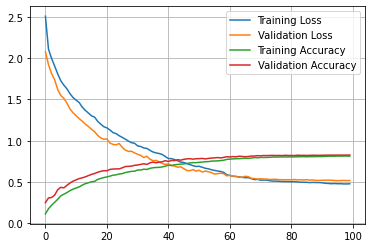

In [ ]:
utils.plot_history(history)

## Train a Regular ResNet20 Model

In [ ]:
with strategy.scope():
    model = utils.get_training_model()

model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

start = time.time()
history = model.fit(train_ds,
                   validation_data=test_ds,
                   callbacks=train_callbacks,
                   epochs=200) # 200 eppochs since SAM takes two backprop steps for an update
print(f"Total training time: {(time.time() - start)/60.} minutes")

Epoch 1/200
49/49 [==============================] - 33s 327ms/step - loss: 1.8834 - accuracy: 0.3003 - val_loss: 2.3113 - val_accuracy: 0.1941 - lr: 0.0010
Epoch 2/200
49/49 [==============================] - 3s 67ms/step - loss: 1.5860 - accuracy: 0.4219 - val_loss: 4.6501 - val_accuracy: 0.1330 - lr: 0.0010
Epoch 3/200
49/49 [==============================] - 3s 67ms/step - loss: 1.4131 - accuracy: 0.4877 - val_loss: 4.4304 - val_accuracy: 0.1388 - lr: 0.0010
Epoch 4/200
49/49 [==============================] - ETA: 0s - loss: 1.2977 - accuracy: 0.5359
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
49/49 [==============================] - 4s 75ms/step - loss: 1.2977 - accuracy: 0.5359 - val_loss: 3.5032 - val_accuracy: 0.2005 - lr: 0.0010
Epoch 5/200
49/49 [==============================] - 3s 66ms/step - loss: 1.2055 - accuracy: 0.5689 - val_loss: 2.3880 - val_accuracy: 0.2940 - lr: 5.0000e-04
Epoch 6/200
49/49 [==============================] - 4s 

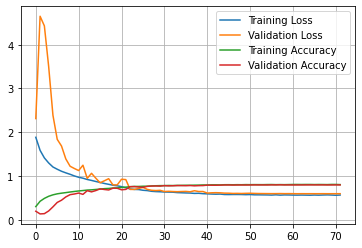

In [ ]:
utils.plot_history(history)